Snapshots of U, V, W on the sloped rim of the canyon as daily averages (day 1 to day 15). Run on Salish computer. 

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/transport_fluxes/')
import functions_transport_W

%matplotlib inline

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'
gdepw, tmask, mbathy, e1t, e2t = functions_transport_W.get_variables_planes(dirname, filename)
filename = '1_mesh_mask_nocanyon.nc'
gdepwn, tmaskn, mbathyn, e1tn, e2tn = functions_transport_W.get_variables_planes(dirname, filename)

In [4]:
surface_mask = functions_transport_W.get_surface_mask(tmaskn, mbathyn)

In [5]:
def get_variables_fluxes(dirname, fname, surface_mask, grid_type):
    
    files = get_files(dirname, fname, grid_type)
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    if grid_type == 'grid_U':
        var_name = 'vozocrtx'
    elif grid_type == 'grid_V':
        var_name = 'vomecrty'
    elif grid_type == 'grid_W':
        var_name = 'vovecrtz'

    with scDataset(files) as ds:
        vel0 = ds.variables[var_name][:,:,y,x]
    print('vel0')
        
    surface_mask_f = np.tile(surface_mask, (vel0.shape[0], 1, 1, 1))

    vel = np.ma.array(vel0, mask=1 - surface_mask_f)
    
    return vel

In [6]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [7]:
def plot_vel_snapshots(vel_all, xs, ys, vm, ttl):
    cmap = plt.get_cmap(cm.RdBu_r)
    #cmap.set_bad('wheat')
    fig, axes = plt.subplots(3, 5, figsize=(20,15), sharey=True)
    for ax, n in zip(axes.flatten(), np.arange(15)):
        vel_dayn = get_1day_avg(vel_all, n, n+1)
        for dep in range(vel_dayn.shape[-3]):
            p = ax.pcolormesh(xs, ys, vel_dayn[dep, :, :], vmin=-1*vm, vmax=vm, cmap=cmap)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlim([0, xs[-1]])
        ax.set_ylim([0, ys[-1]])
        ax.set_title('Day '+str(n+1), fontsize=16)
        if n==0:
            fig.colorbar(p, ax=ax)
    fig.tight_layout(w_pad=0.1, h_pad=0.25)
    fig.suptitle(ttl+' Velocity Profile of the Sloped Rim', fontsize=20)
    plt.subplots_adjust(top=0.92)
    return fig

In [8]:
fname = "1_MCKNZ_1h_20170101_20170120_*"
vozocrtx = get_variables_fluxes(dirname, fname, surface_mask, 'grid_U')

xs = np.arange(vozocrtx.shape[-1])
ys = np.arange(vozocrtx.shape[-2])

files
vel0


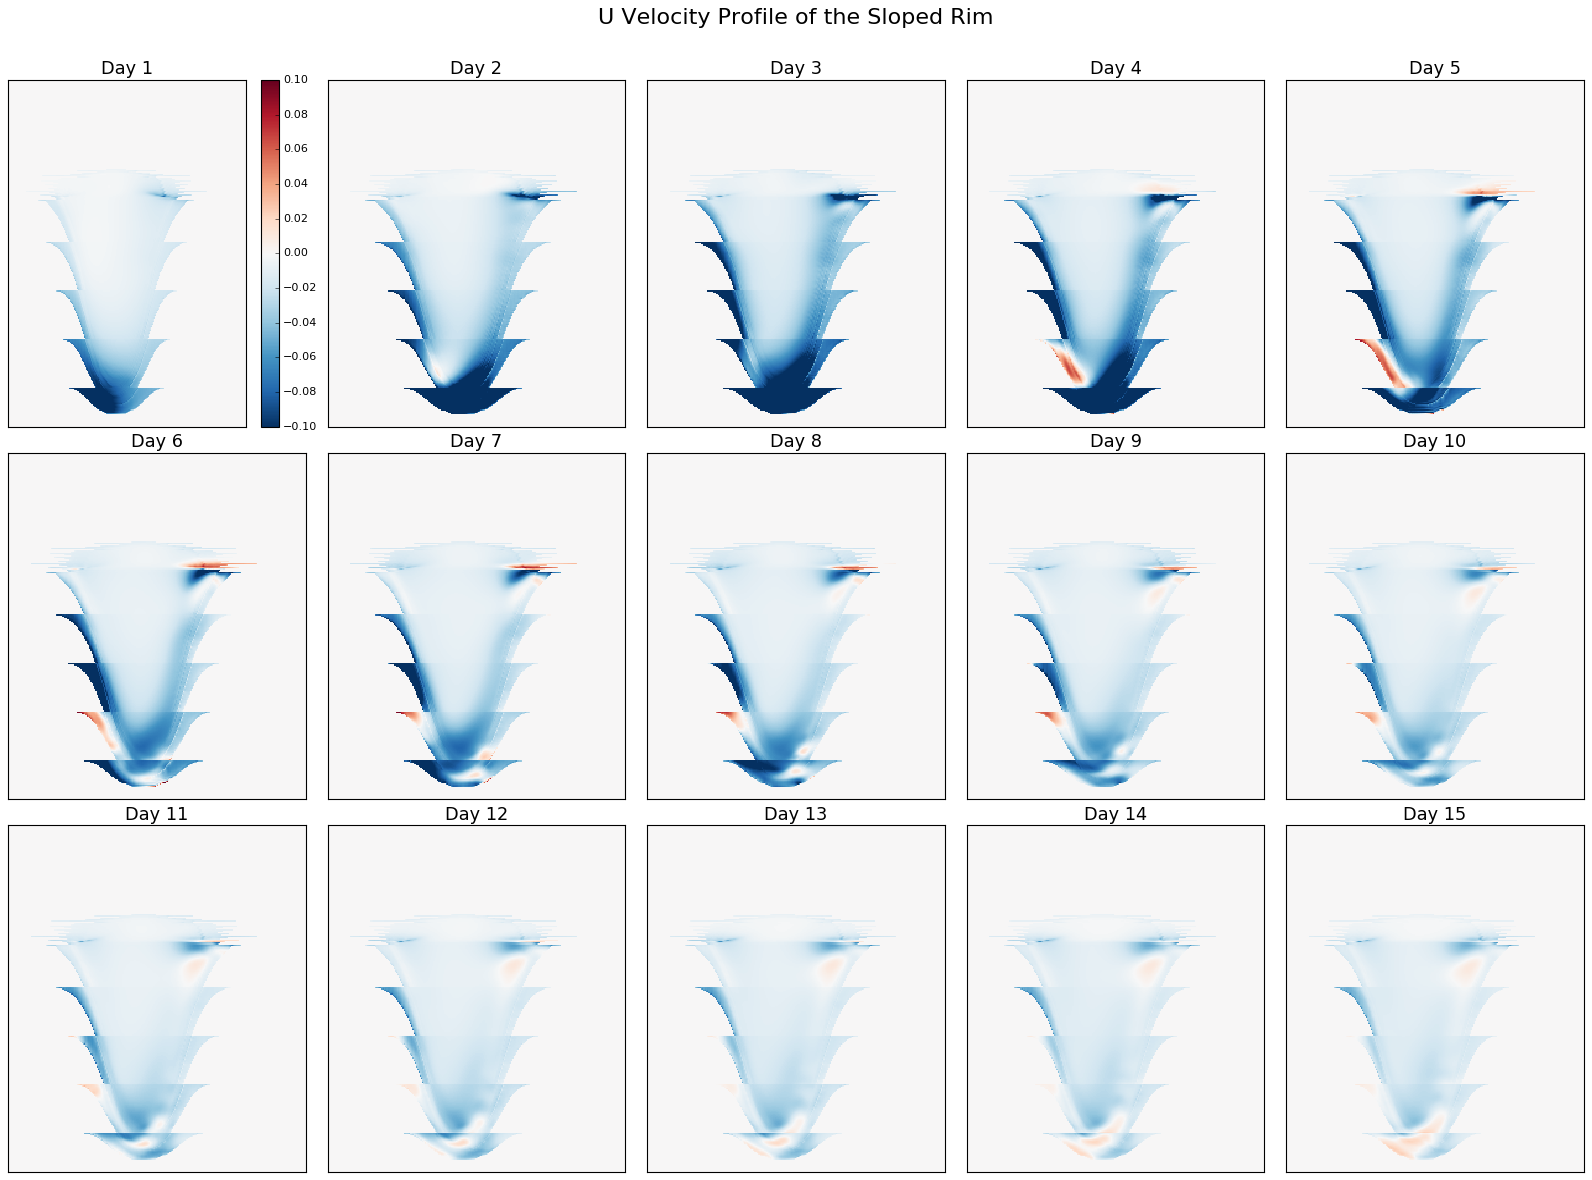

In [9]:
fig = plot_vel_snapshots(vozocrtx, xs, ys, 0.1, 'U')

In [10]:
vomecrty = get_variables_fluxes(dirname, fname, surface_mask, 'grid_V')

files
vel0


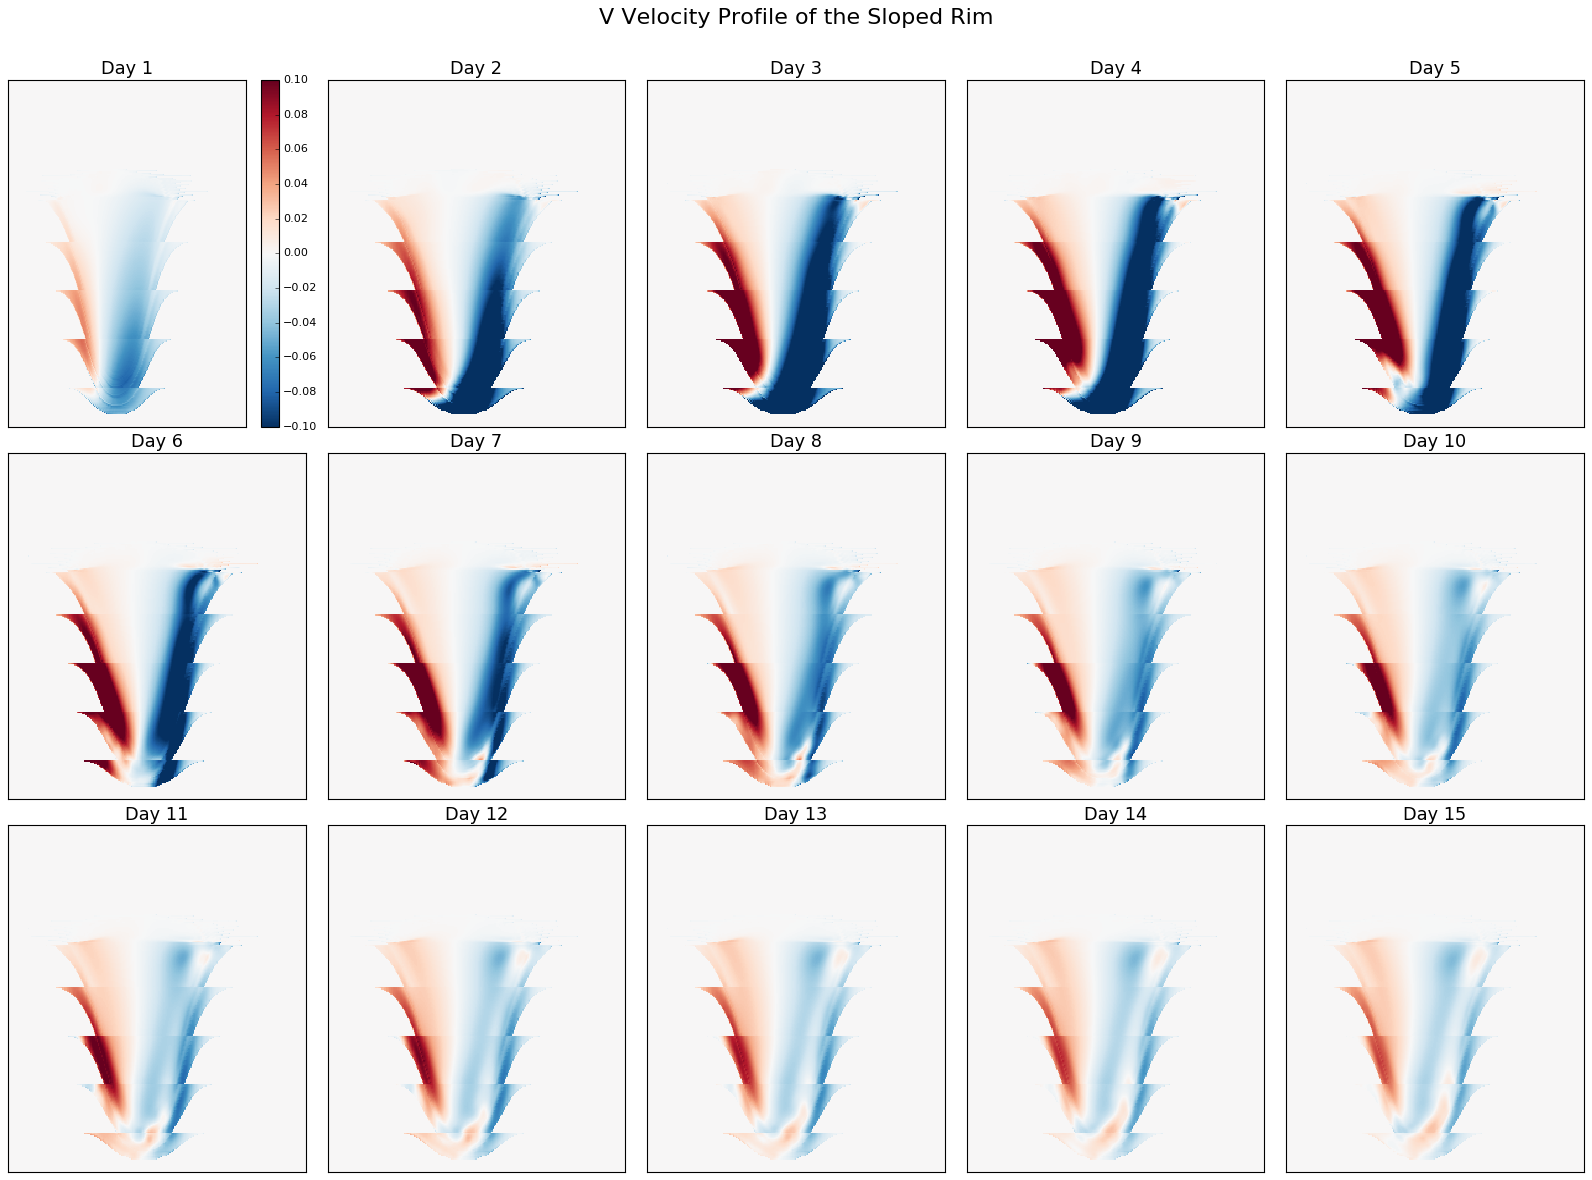

In [11]:
fig = plot_vel_snapshots(vomecrty, xs, ys, 0.1, 'V')

In [12]:
vovecrtz = get_variables_fluxes(dirname, fname, surface_mask, 'grid_W')

files
vel0


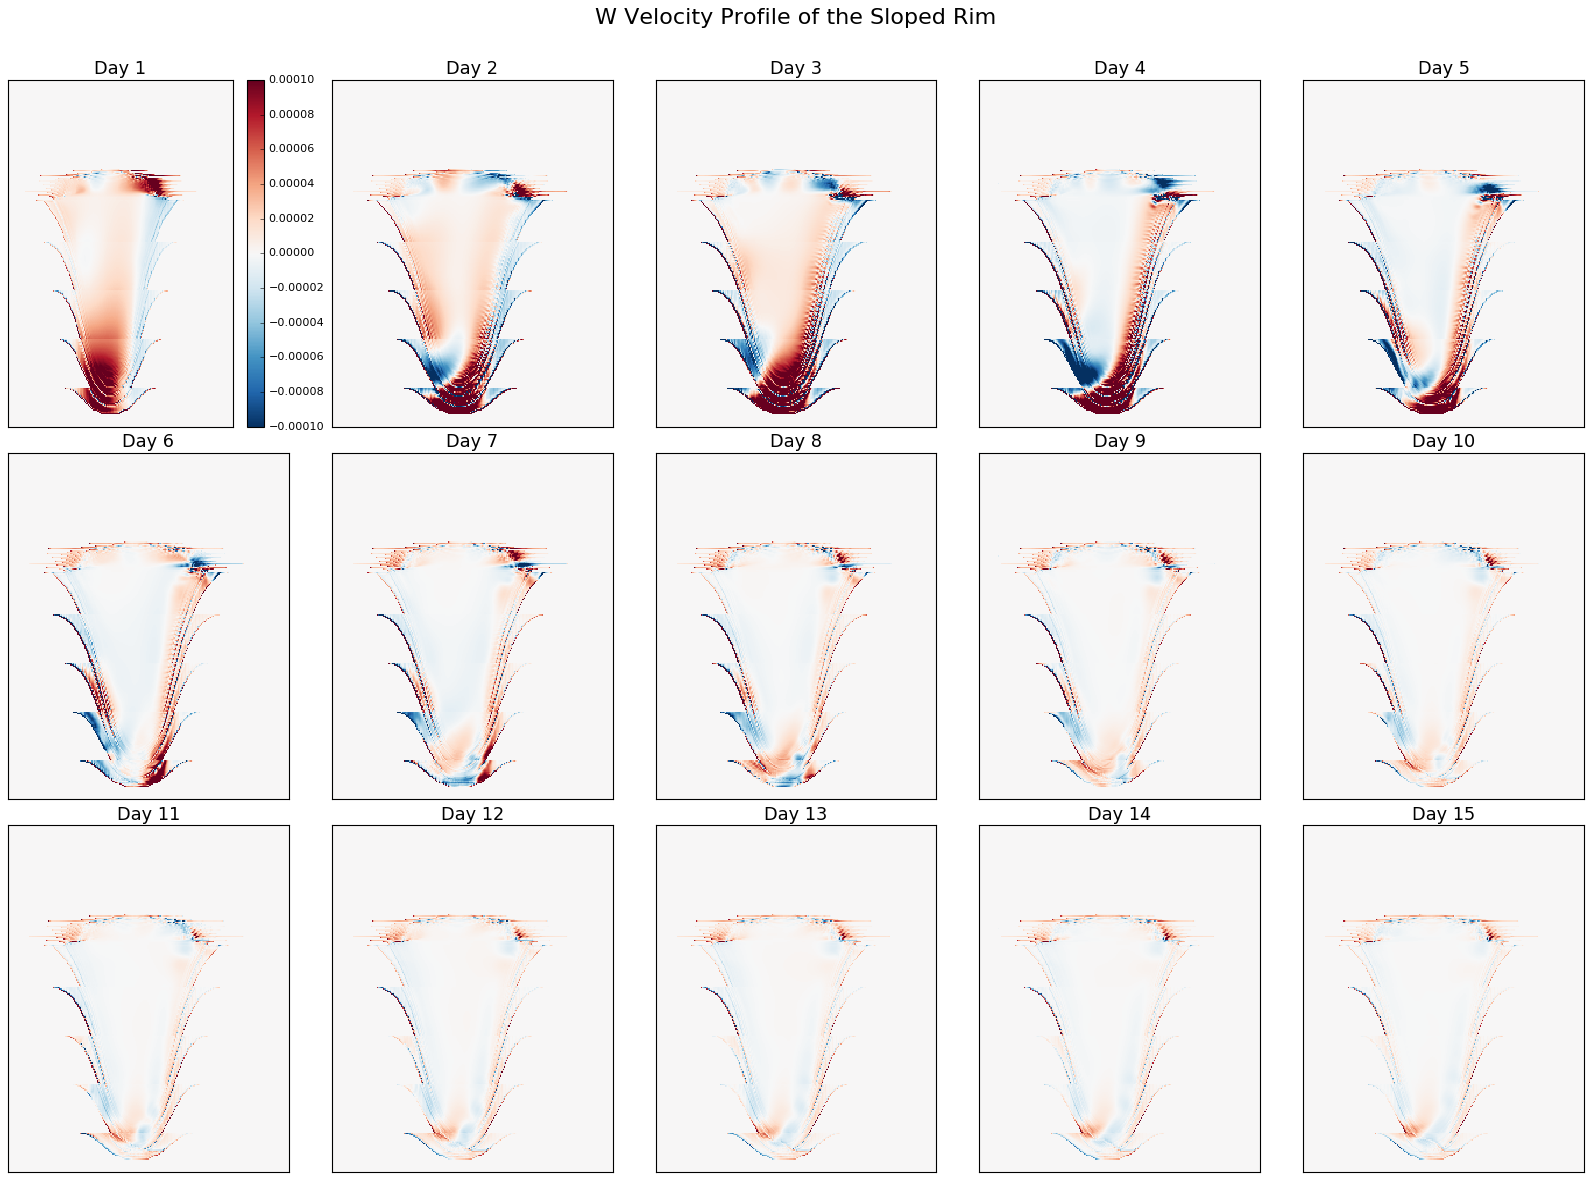

In [13]:
fig = plot_vel_snapshots(vovecrtz, xs, ys, 0.0001, 'W')